In [11]:
import random
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
random.seed(4014)

## Data

In [12]:
movies = pd.read_csv('../../data/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], encoding='ISO-8859-1')
ratings = pd.read_csv('../../data/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='ISO-8859-1')
users = pd.read_csv('../../data/users.dat', sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], encoding='ISO-8859-1')

In [13]:
ratings["like"] = (ratings["rating"] >= 4).astype(int)

df_by_count = ratings.groupby("movie_id").agg(count=("rating", pd.Series.count), 
                                       mean=("rating", pd.Series.mean), 
                                       like_count=("like",pd.Series.sum)).sort_values(by="count", ascending=False)
df_by_count["like_prob"] = df_by_count["like_count"] / df_by_count["count"]
df_by_count.head()

,count,mean,like_count,like_prob
movie_id,,,,
2858,3428,4.317386,2853,0.832264
260,2991,4.453694,2622,0.876630
1196,2990,4.292977,2510,0.839465
1210,2883,4.022893,2127,0.737773
480,2672,3.763847,1730,0.647455


## Define Algorithms

In [14]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

### Epsilon Greedy

In [15]:
class EpsilonGreedy():
    
    def __init__(self, epsilon, counts, values): 
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        return 
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
    
    def select_arm(self):
        if random.random()>self.epsilon:
            m = max(self.values)
            return self.values.index(m)
        else:
            return random.randrange(len(self.values))
        
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm]+1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value + (1/float(n))*reward
        self.values[chosen_arm] = new_value
        return

### UCB 1

In [16]:
class UCB1():
    
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
        
    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm]==0:
                return arm
        
        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts=sum(self.counts)
        for arm in range(n_arms):
            bonus = math.sqrt((2*math.log(total_counts))/(float(self.counts[arm])))
            ucb_values[arm] = self.values[arm] + bonus                        
        
        return ucb_values.index(max(ucb_values))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return

### Thompson Sampling

In [17]:
class ThompsonSampling():
    
    def __init__(self,counts,values,init_alpha=1,init_beta=1):
        self.counts = counts
        self.values = values
        self.init_alpha = init_alpha
        self.init_beta = init_beta
        self.alphas = []
        self.betas = []
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        self.alphas = [self.init_alpha]*n_arms
        self.betas = [self.init_beta]*n_arms
        return
        
    def select_arm(self):
        best_arm = max(
            range(len(self.counts)),
            key=lambda x: np.random.beta(self.alphas[x],self.betas[x])
        )  
        return best_arm
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        # update alphas and betas
        self.alphas[chosen_arm] += reward
        self.betas[chosen_arm] += (1-reward)
        return

### Test Algorithm Function

In [18]:
def test_algorithm (algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize (len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t -1 
            sim_nums[index] = sim
            times[index] = t
            
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward

            algo.update(chosen_arm, reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

#### Top 30 Movies by count

In [78]:
top_30_agg = df_by_count.iloc[:30,:]
top_30_agg.head()

,count,mean,like_count,like_prob
movie_id,,,,
2858,3428,4.317386,2853,0.832264
260,2991,4.453694,2622,0.876630
1196,2990,4.292977,2510,0.839465
1210,2883,4.022893,2127,0.737773
480,2672,3.763847,1730,0.647455


In [79]:
top_30_movies = top_30_agg.index.tolist()
df_top_30 = ratings[ratings["movie_id"].isin(top_30_movies)]
df_top_30.head()

,user_id,movie_id,rating,timestamp,like
5,1,1197,3,978302268,0
22,1,1270,5,978300055,1
23,1,527,5,978824195,1
26,1,1097,4,978301953,1
38,1,2762,4,978302091,1


#### Run Algorithms

In [80]:
n_arms = 30
mus = top_30_agg["like_prob"].tolist()
arms = list(map(lambda mu: BernoulliArm(mu), mus))

# initialization, arguments
N_SIMULATIONS = 50
N_STEPS = 1000

# Store final results
results_list = []

# Run Epsilon Decay
for epsilon in [0.1,0.5,0.9]:
    algo = EpsilonGreedy(epsilon,[],[])
    algo.initialize(n_arms)
    results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
    results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
    results['name'] = 'Epsilon Greedy' + ' ' + str(epsilon)
    results_list.append(results)


# Run UCB1
algo = UCB1([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'UCB1'
results_list.append(results)


# Run Thompson Sampling
algo = ThompsonSampling([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Thompson Sampling'
results_list.append(results)


results_30 = pd.concat(results_list)
results_30.head()

,n_sim,n_step,chosen_arm,rewards,cumulative_rewards,name
0,1.0,1.0,0.0,1.0,1.0,Epsilon Greedy 0.1
1,1.0,2.0,0.0,1.0,2.0,Epsilon Greedy 0.1
2,1.0,3.0,0.0,1.0,3.0,Epsilon Greedy 0.1
3,1.0,4.0,0.0,1.0,4.0,Epsilon Greedy 0.1
4,1.0,5.0,0.0,1.0,5.0,Epsilon Greedy 0.1


#### Visualize Results

In [81]:
# Optimal Results
optimal_movie = np.argmax(top_30_agg["like_prob"].tolist())
optimal_cum_reward = top_30_agg["like_prob"].tolist()[optimal_movie]*1000

Text(0.5, 1.0, 'Cumulative Rewards at Each Step')

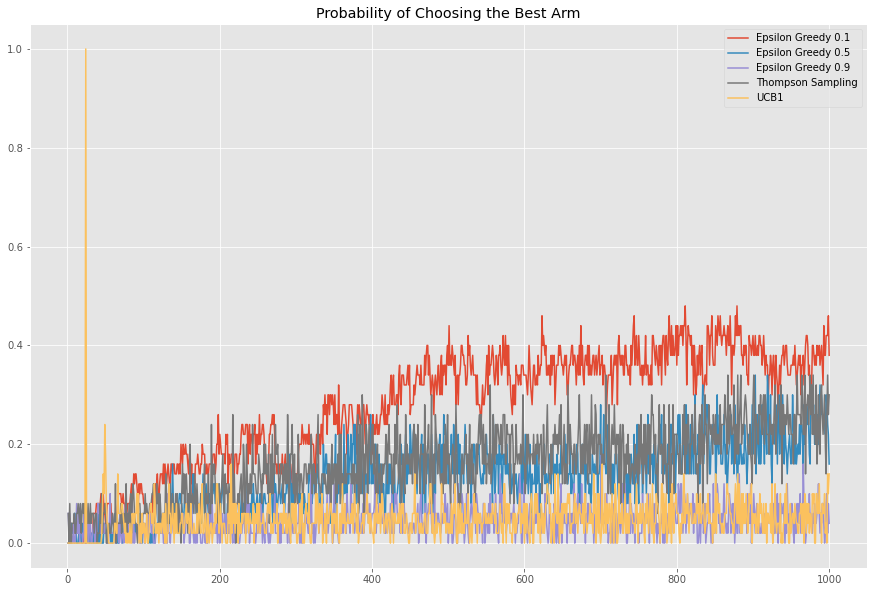

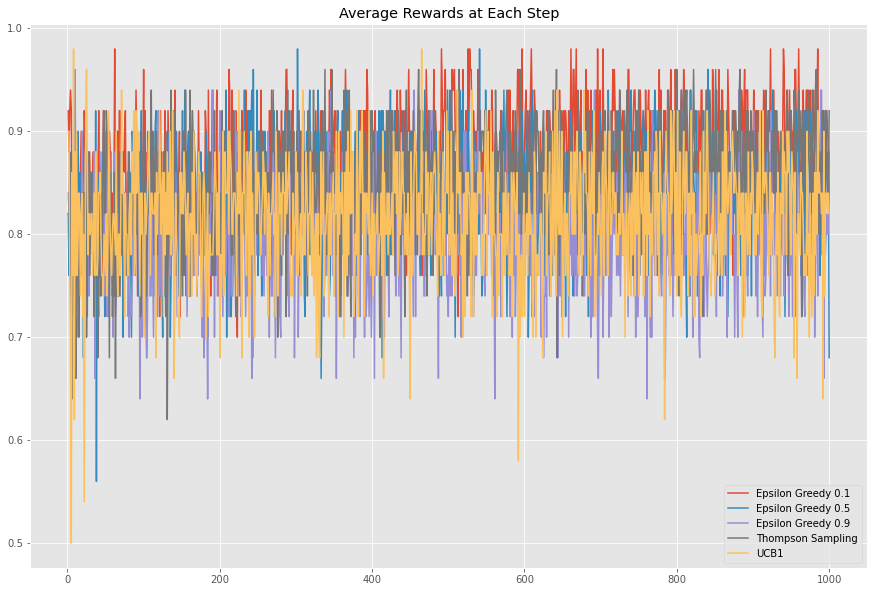

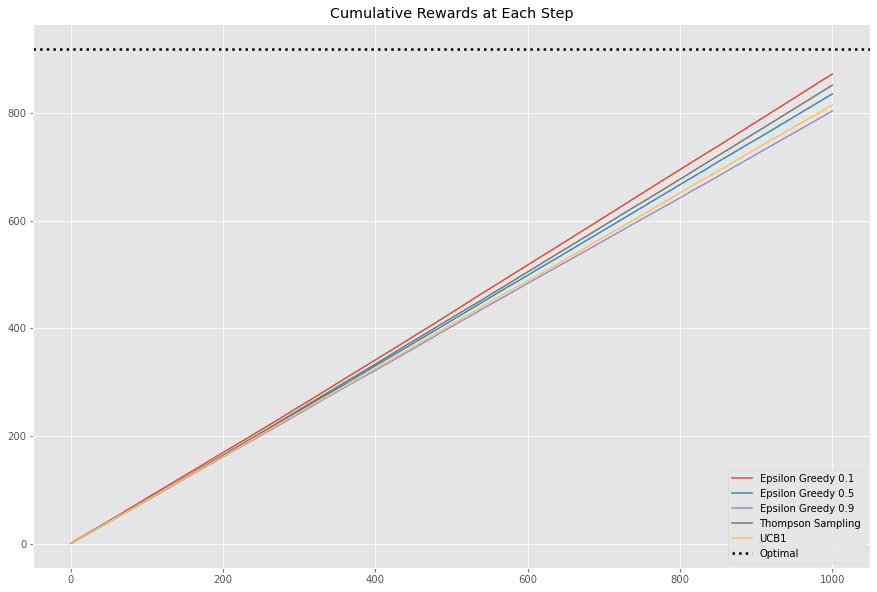

In [82]:
results_30['if_best_arm'] = np.where(results_30['chosen_arm']==optimal_movie, 1,0)

results_plot = results_30.groupby(['name','n_step'],as_index=False).aggregate({'if_best_arm':lambda x: x.sum()/(x.count()+0.0),'rewards':'mean', 'cumulative_rewards':'mean'})
plt.style.use('ggplot')

# plot for the best arm
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['if_best_arm'], label=str(name))
plt.legend()
plt.title('Probability of Choosing the Best Arm')
# plt.savefig('best_arms'+suffix+'.png', dpi=300)

# plot for average rewards
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['rewards'], label=str(name))
plt.legend()
plt.title('Average Rewards at Each Step')
# plt.savefig('avg_rewards'+suffix+'.png', dpi=300)

# plot for cumulative rewards
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique(): 
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['cumulative_rewards'], label=str(name))

# plot optimal cumulative rewards
ax.axhline(y=optimal_cum_reward, color='k', linestyle=':', linewidth=2.5, label="Optimal")

plt.legend()
plt.title('Cumulative Rewards at Each Step')
# plt.savefig('cumulative_rewards'+suffix+'.png', dpi=300)

In [83]:
results_plot

,name,n_step,if_best_arm,rewards,cumulative_rewards
0,Epsilon Greedy 0.1,1.0,0.00,0.92,0.92
1,Epsilon Greedy 0.1,2.0,0.00,0.88,1.80
2,Epsilon Greedy 0.1,3.0,0.02,0.92,2.72
3,Epsilon Greedy 0.1,4.0,0.04,0.94,3.66
4,Epsilon Greedy 0.1,5.0,0.04,0.92,4.58
...,...,...,...,...,...
4995,UCB1,996.0,0.04,0.84,811.02
4996,UCB1,997.0,0.00,0.84,811.86
4997,UCB1,998.0,0.14,0.82,812.68
4998,UCB1,999.0,0.10,0.84,813.52


#### Regret Comparison

In [25]:
# Compare Algo to Optimal
algo_name = ["Epsilon Greedy 0.1","Epsilon Greedy 0.5","Epsilon Greedy 0.9", "UCB1", "Thompson Sampling"]
cum_reward_mean = []
regret_percent = []


for i in range(len(algo_name)):
    filtered = results_30[(results_30["name"] == algo_name[i]) & (results_30["n_step"]==1000)]
    mean = filtered["cumulative_rewards"].mean()
    cum_reward_mean.append(mean)
    regret = round((optimal_cum_reward - mean) / optimal_cum_reward,2)
    regret_percent.append(regret)
    
data = {
    'Algorithm Name': algo_name,
    'Cummulative Reward': cum_reward_mean,
    'Regret Percentage': regret_percent
}

regret_30 = pd.DataFrame(data)
regret_30

,Algorithm Name,Cummulative Reward,Regret Percentage
0,Epsilon Greedy 0.1,867.88,0.06
1,Epsilon Greedy 0.5,833.64,0.09
2,Epsilon Greedy 0.9,802.00,0.13
3,UCB1,812.92,0.12
4,Thompson Sampling,848.18,0.08


## Using our popularity function

In [49]:
def popularity_recommendation(data):
    data["like"] = (data["rating"] >= 4).astype(int)
    df_by_count = data.groupby("movie_id").agg(vote_count=("rating", pd.Series.count), 
                                       vote_average=("rating", pd.Series.mean), 
                                       like_count=("like",pd.Series.sum)).reset_index().sort_values(by="vote_count", ascending=False)
    df_by_count["like_prob"] = df_by_count["like_count"] / df_by_count["vote_count"]

    vote_counts = df_by_count[df_by_count['vote_count'].notnull()]['vote_count'].astype('int')
    votes_average = df_by_count[df_by_count['vote_average'].notnull()]['vote_average'].astype('int')

    C = votes_average.mean()
    m = vote_counts.quantile(0.85)

    def weighted_rating(x):
        v = x['vote_count']
        R = x['vote_average']
        return (v/(v+m) * R) + (m/(m+v) * C)

    qualified = df_by_count[(df_by_count['vote_count'] >= m) & (df_by_count['vote_count'].notnull()) & 
               (df_by_count['vote_average'].notnull())][['movie_id', 'vote_count', 'vote_average', 'like_count', 'like_prob']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['weighted_rat'] = qualified.apply(weighted_rating, axis=1)
    result = qualified.sort_values('weighted_rat', ascending=False).head(30).reset_index()
    return result

In [50]:
top_30_agg = popularity_recommendation(ratings)
top_30_agg.head()

,index,movie_id,vote_count,vote_average,like_count,like_prob,weighted_rat
0,2651,2858,3428,4,2853,0.832264,3.828001
1,253,260,2991,4,2622,0.876630,3.806794
2,1106,1196,2990,4,2510,0.839465,3.806740
3,1120,1210,2883,4,2127,0.737773,3.800722
4,1848,2028,2653,4,2260,0.851866,3.786426


In [51]:
top_30_movies = top_30_agg['movie_id'].tolist()
df_top_30 = ratings[ratings["movie_id"].isin(top_30_movies)]
df_top_30.head()

,user_id,movie_id,rating,timestamp,like
5,1,1197,3,978302268,0
23,1,527,5,978824195,1
38,1,2762,4,978302091,1
40,1,1,5,978824268,1
44,1,260,4,978300760,1


#### Run Algorithms

In [52]:
n_arms = 30
mus = top_30_agg["like_prob"].tolist()
arms = list(map(lambda mu: BernoulliArm(mu), mus))

# initialization, arguments
N_SIMULATIONS = 50
N_STEPS = 1000

# Store final results
results_list = []

# Run Epsilon Decay
for epsilon in [0.1,0.5,0.9]:
    algo = EpsilonGreedy(epsilon,[],[])
    algo.initialize(n_arms)
    results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
    results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
    results['name'] = 'Epsilon Greedy' + ' ' + str(epsilon)
    results_list.append(results)


# Run UCB1
algo = UCB1([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'UCB1'
results_list.append(results)


# Run Thompson Sampling
algo = ThompsonSampling([],[])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Thompson Sampling'
results_list.append(results)


results_30 = pd.concat(results_list)
results_30.head()

,n_sim,n_step,chosen_arm,rewards,cumulative_rewards,name
0,1.0,1.0,8.0,0.0,0.0,Epsilon Greedy 0.1
1,1.0,2.0,0.0,0.0,0.0,Epsilon Greedy 0.1
2,1.0,3.0,0.0,1.0,1.0,Epsilon Greedy 0.1
3,1.0,4.0,0.0,1.0,2.0,Epsilon Greedy 0.1
4,1.0,5.0,0.0,1.0,3.0,Epsilon Greedy 0.1


#### Visualize Results

In [53]:
# Optimal Results
optimal_movie = np.argmax(top_30_agg["like_prob"].tolist())
optimal_cum_reward = top_30_agg["like_prob"].tolist()[optimal_movie]*1000

In [54]:
results_30['if_best_arm'] = np.where(results_30['chosen_arm']==optimal_movie, 1,0)
results_30

,n_sim,n_step,chosen_arm,rewards,cumulative_rewards,name,if_best_arm
0,1.0,1.0,8.0,0.0,0.0,Epsilon Greedy 0.1,0
1,1.0,2.0,0.0,0.0,0.0,Epsilon Greedy 0.1,0
2,1.0,3.0,0.0,1.0,1.0,Epsilon Greedy 0.1,0
3,1.0,4.0,0.0,1.0,2.0,Epsilon Greedy 0.1,0
4,1.0,5.0,0.0,1.0,3.0,Epsilon Greedy 0.1,0
...,...,...,...,...,...,...,...
49995,50.0,996.0,6.0,1.0,840.0,Thompson Sampling,0
49996,50.0,997.0,6.0,1.0,841.0,Thompson Sampling,0
49997,50.0,998.0,6.0,1.0,842.0,Thompson Sampling,0
49998,50.0,999.0,6.0,1.0,843.0,Thompson Sampling,0


Text(0.5, 1.0, 'Cumulative Rewards at Each Step')

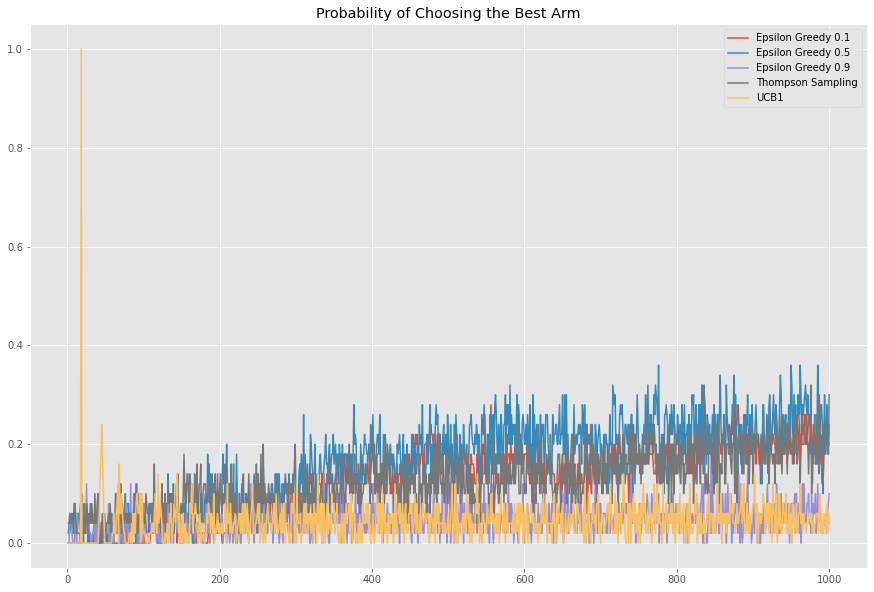

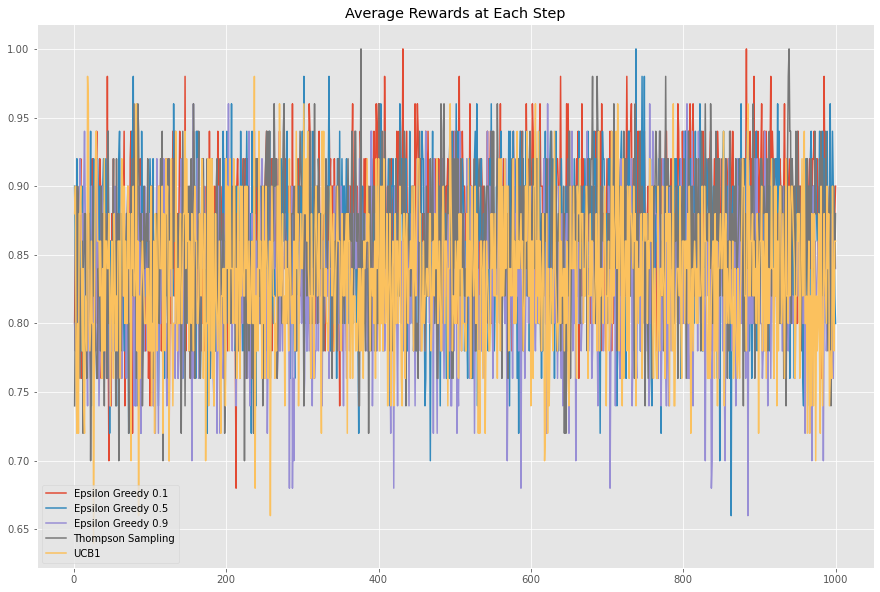

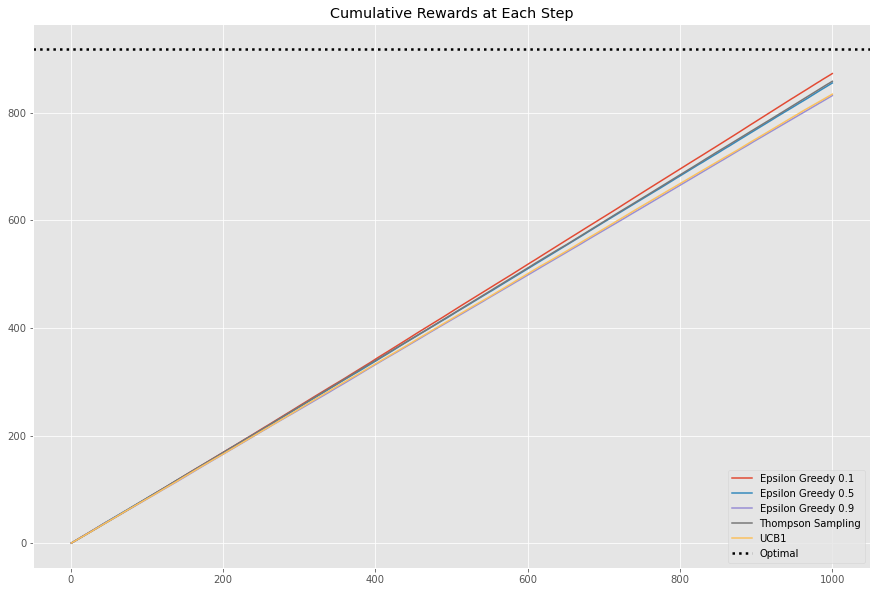

In [55]:
results_30['if_best_arm'] = np.where(results_30['chosen_arm']==optimal_movie, 1,0)

results_plot = results_30.groupby(['name','n_step'],as_index=False).aggregate({'if_best_arm':lambda x: x.sum()/(x.count()+0.0),'rewards':'mean', 'cumulative_rewards':'mean'})
plt.style.use('ggplot')

# plot for the best arm
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['if_best_arm'], label=str(name))
plt.legend()
plt.title('Probability of Choosing the Best Arm')
# plt.savefig('best_arms'+suffix+'.png', dpi=300)

# plot for average rewards
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['rewards'], label=str(name))
plt.legend()
plt.title('Average Rewards at Each Step')
# plt.savefig('avg_rewards'+suffix+'.png', dpi=300)

# plot for cumulative rewards
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for name in results_plot['name'].unique(): 
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['cumulative_rewards'], label=str(name))

# plot optimal cumulative rewards
ax.axhline(y=optimal_cum_reward, color='k', linestyle=':', linewidth=2.5, label="Optimal")

plt.legend()
plt.title('Cumulative Rewards at Each Step')
# plt.savefig('cumulative_rewards'+suffix+'.png', dpi=300)

#### Regret Comparison

In [56]:
# Compare Algo to Optimal
algo_name = ["Epsilon Greedy 0.1","Epsilon Greedy 0.5","Epsilon Greedy 0.9", "UCB1", "Thompson Sampling"]
cum_reward_mean = []
regret_percent = []


for i in range(len(algo_name)):
    filtered = results_30[(results_30["name"] == algo_name[i]) & (results_30["n_step"]==1000)]
    mean = filtered["cumulative_rewards"].mean()
    cum_reward_mean.append(mean)
    regret = round((optimal_cum_reward - mean) / optimal_cum_reward,2)
    regret_percent.append(regret)
    
data = {
    'Algorithm Name': algo_name,
    'Cummulative Reward': cum_reward_mean,
    'Regret Percentage': regret_percent
}

regret_30 = pd.DataFrame(data)
regret_30

,Algorithm Name,Cummulative Reward,Regret Percentage
0,Epsilon Greedy 0.1,872.92,0.05
1,Epsilon Greedy 0.5,855.38,0.07
2,Epsilon Greedy 0.9,831.96,0.09
3,UCB1,834.64,0.09
4,Thompson Sampling,858.56,0.07


In [84]:
def epsilon_greedy_policy(history, arms, epsilon=0.1):
    scores = pd.DataFrame(data=None)
    # randomly select between 1 and 0 with a probability of epsilon:1 
    explore = np.random.binomial(1, epsilon)
    
    # if the explore, randomly select from all possible arms
    if explore == 1 or history.shape[0] == 0:
        rec = np.random.choice(arms, replace=False)
    # if exploit, choose the arm from history with the highest rate 
    else:
        ranks = history.sort_values (by=['mean'], ascending=False) 
        rec = ranks.iloc[0]['arm']
    return rec

In [87]:
arms = ratings.groupby('movie_id')['rating'].count().sort_values(ascending=False).head(30).index.tolist()
data = ratings[ratings['movie_id'].isin(arms)]
k = data['movie_id'].nunique()
t = data.shape[0]

In [94]:
data.head()

,user_id,movie_id,rating,timestamp,like
5,1,1197,3,978302268,0
22,1,1270,5,978300055,1
23,1,527,5,978824195,1
26,1,1097,4,978301953,1
38,1,2762,4,978302091,1


In [90]:
algos = [epsilon_greedy_policy]


# define a dataframe for evaluation results
evaluation_cols = ['step', 'chosen_arm', 'reward', 'round', 'policy']
evaluation = []


# define a list to save all arm-play statistics
play_stats = []
       
for f in algos:

    # define a container to store all knowledge you have learned for arm
    container_cols = ['arm', 'sum', 'mean', 'count']
    container = pd.DataFrame(data=None, columns=container_cols)
    container = container.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float'})
    for j in range(0,len(arms)):
        container.loc[j] = [arms[j],0,0,0]
    
    step = 0
    for i in range(1,t+1):
        # get recommendation from the algorithm
        rec_a = f(container, arms)

        # check if the recommendation matches the record at the step
        # if it does match, add to history so that the reward of this record can be revealed to the algorithm
        if rec_a==data.iloc[i-1]['movie_id']:
            step = step + 1
            action = data.iloc[i-1]['movie_id']
            reward = data.iloc[i-1]['like']

            eva_rec = {'policy':f.__name__,'log_step':i,'play_step':step,'chosen_arm':action,'reward':reward}
            evaluation.append(eva_rec)

            container['count'] = np.where(container['arm']==action, container['count'] +1, container['count'])
            container['sum'] = np.where(container['arm']==action, container['sum'] +reward, container['sum'])
            container['mean'] = np.where(container['arm']==action, container['sum']/(container['count']+0.0), container['mean'])

        #if it does not match, discard and move to the next iteration 
        else:
            continue
    container['policy'] = f.__name__
    play_stats.append(container)

# summarize all rounds, calculate the aerage
evaluation = pd.DataFrame(evaluation)
evaluation = evaluation.sort_values(by=['policy','play_step'])
evaluation['cumulative_rewards'] = evaluation.groupby(['policy'])['reward'].cumsum()
play_stats = pd.concat(play_stats)

In [92]:
play_stats.head()

,arm,sum,mean,count,policy
0,2858,33,0.804878,41,epsilon_greedy_policy
1,260,7,0.777778,9,epsilon_greedy_policy
2,1196,34,0.871795,39,epsilon_greedy_policy
3,1210,8,0.727273,11,epsilon_greedy_policy
4,480,13,0.764706,17,epsilon_greedy_policy


In [102]:
results_30.head()

,n_sim,n_step,chosen_arm,rewards,cumulative_rewards,name,if_best_arm
0,1.0,1.0,0.0,1.0,1.0,Epsilon Greedy 0.1,0
1,1.0,2.0,0.0,1.0,2.0,Epsilon Greedy 0.1,0
2,1.0,3.0,0.0,1.0,3.0,Epsilon Greedy 0.1,0
3,1.0,4.0,0.0,1.0,4.0,Epsilon Greedy 0.1,0
4,1.0,5.0,0.0,1.0,5.0,Epsilon Greedy 0.1,0


In [93]:
evaluation.head()

,policy,log_step,play_step,chosen_arm,reward,cumulative_rewards
0,epsilon_greedy_policy,29,1,2858,1,1
1,epsilon_greedy_policy,48,2,2858,1,2
2,epsilon_greedy_policy,60,3,2858,0,2
3,epsilon_greedy_policy,62,4,2396,1,3
4,epsilon_greedy_policy,84,5,2396,1,4


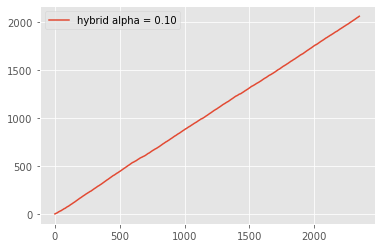

In [109]:
plt.plot(evaluation["cumulative_rewards"], label = "hybrid alpha = 0.10")
# plt.plot(evaluation["cumulative_rewards"], label = "disjoint alpha = 0.10")
plt.legend()

Text(0.5, 1.0, 'Probability of Choosing the Best Arm')

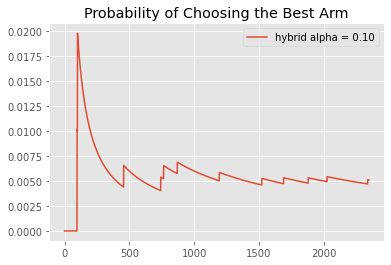

In [111]:
best_arm_disjoint = data.groupby('movie_id')['like'].mean().idxmax()

evaluation['if_best_arm'] = np.where(evaluation['chosen_arm']==best_arm_disjoint, 1,0)


# plot for the best arm
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(evaluation['if_best_arm'].cumsum() / np.arange(1, len(evaluation['if_best_arm']) + 1), label = "hybrid alpha = 0.10")
plt.legend()
plt.title('Probability of Choosing the Best Arm')

In [100]:
data.groupby('movie_id')['like'].mean().idxmax()

318

In [106]:
optimal_movie = data.groupby('movie_id')['like'].mean().idxmax()
# optimal_cum_reward = data["like_prob"].tolist()[optimal_movie]*1000

Text(0.5, 1.0, 'Cumulative Rewards at Each Step')

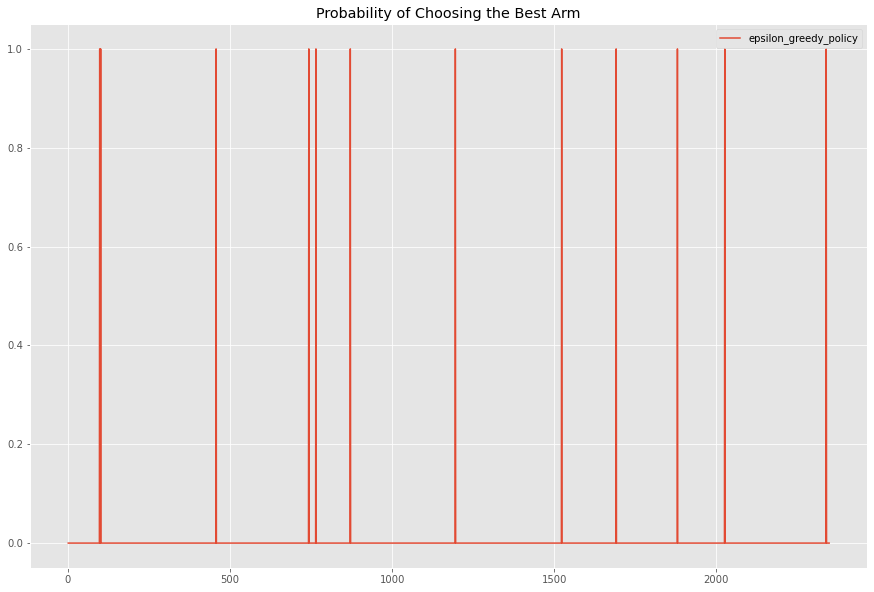

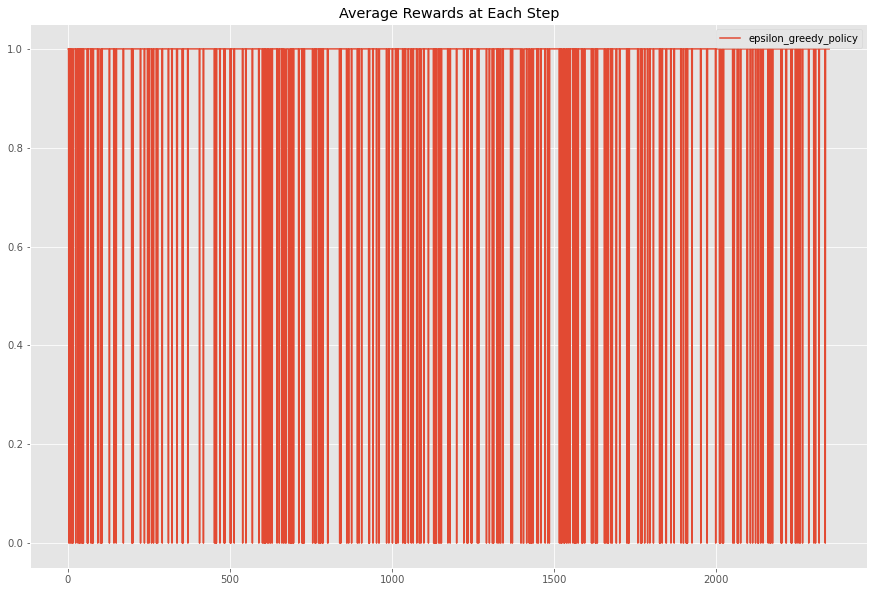

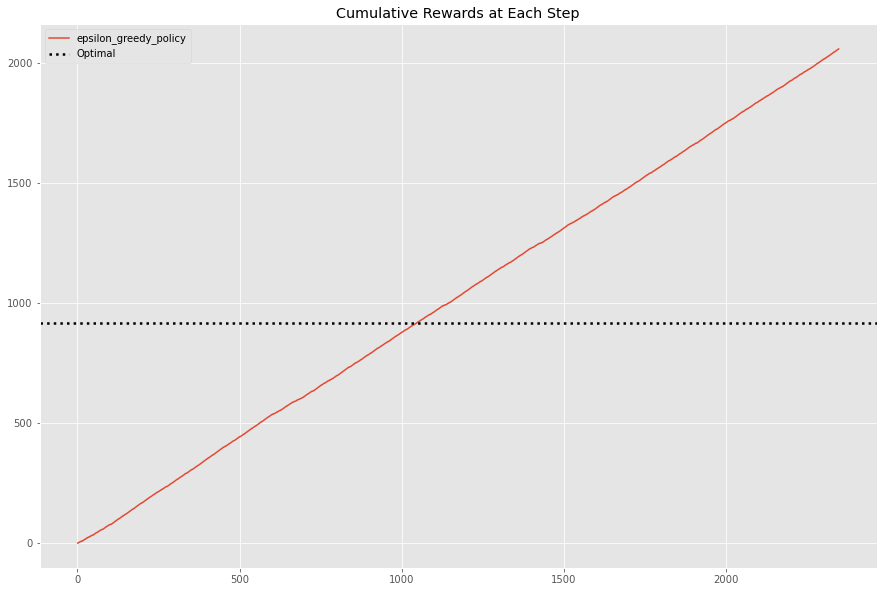

In [108]:
evaluation['if_best_arm'] = np.where(evaluation['chosen_arm']==optimal_movie, 1,0)

results_plot = evaluation.groupby(['policy','play_step'],as_index=False).aggregate({'if_best_arm':lambda x: x.sum()/(x.count()+0.0),'reward':'mean', 'cumulative_rewards':'mean'})
plt.style.use('ggplot')

# plot for the best arm
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for policy in results_plot['policy'].unique():
    ax.plot(results_plot[results_plot['policy']==policy]['play_step'],results_plot[results_plot['policy']==policy]['if_best_arm'], label=str(policy))
plt.legend()
plt.title('Probability of Choosing the Best Arm')
# plt.savefig('best_arms'+suffix+'.png', dpi=300)

# plot for average rewards
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for policy in results_plot['policy'].unique():
    ax.plot(results_plot[results_plot['policy']==policy]['play_step'],results_plot[results_plot['policy']==policy]['reward'], label=str(policy))
plt.legend()
plt.title('Average Rewards at Each Step')
# plt.savefig('avg_rewards'+suffix+'.png', dpi=300)

# plot for cumulative rewards
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
for policy in results_plot['policy'].unique(): 
    ax.plot(results_plot[results_plot['policy']==policy]['play_step'],results_plot[results_plot['policy']==policy]['cumulative_rewards'], label=str(policy))

# plot optimal cumulative rewards
ax.axhline(y=optimal_cum_reward, color='k', linestyle=':', linewidth=2.5, label="Optimal")

plt.legend()
plt.title('Cumulative Rewards at Each Step')
# plt.savefig('cumulative_rewards'+suffix+'.png', dpi=300)